In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Load data 


wcad_df=pd.read_csv('FAOSTAT_data.csv',on_bad_lines='skip')
yield_df=pd.read_csv("Yield Data.csv")

In [3]:
#select relevent columns

wcad_df = wcad_df[['Area', 'Census Year', 'Element', 'Item', 'Value']]
wcad_df = wcad_df.rename(columns={'Area': 'Country', 'Census Year': 'Year'})

In [4]:
yield_df = yield_df[['Area', 'Year', 'Element', 'Item', 'Value']]
yield_df = yield_df.rename(columns={'Area': 'Country'})

In [5]:
#Transform into wide format to prepare it for clean analysis and merging.

In [6]:
# WCAD Pivot

wcad_pivot = wcad_df.pivot_table(index=['Country', 'Year'], 
                                  columns=['Element'], 
                                  values='Value', 
                                  aggfunc='first').reset_index()

In [7]:
# Yield Pivot

yield_pivot = yield_df.pivot_table(index=['Country', 'Year', 'Item'], 
                                   columns='Element', 
                                   values='Value', 
                                   aggfunc='first').reset_index()

In [8]:
# Keep only the first 4-digit year

wcad_pivot['Year'] = wcad_pivot['Year'].astype(str).str.extract(r'(\d{4})').astype(int)

In [9]:
# Convert Year to integer in both DataFrames

yield_pivot['Year'] = yield_pivot['Year'].astype(int)
wcad_pivot['Year'] = wcad_pivot['Year'].astype(int)

In [10]:
merged_df = pd.merge(yield_pivot, wcad_pivot, on=['Country', 'Year'], how='inner')

In [11]:
missing_summary = merged_df.isnull().sum()
missing_percent = merged_df.isnull().mean() * 100

# Drop columns with >50% missing or fill selectively
merged_df = merged_df.dropna(thresh=merged_df.shape[0]*0.5, axis=1)
merged_df = merged_df.dropna()  # or use .fillna() if desired


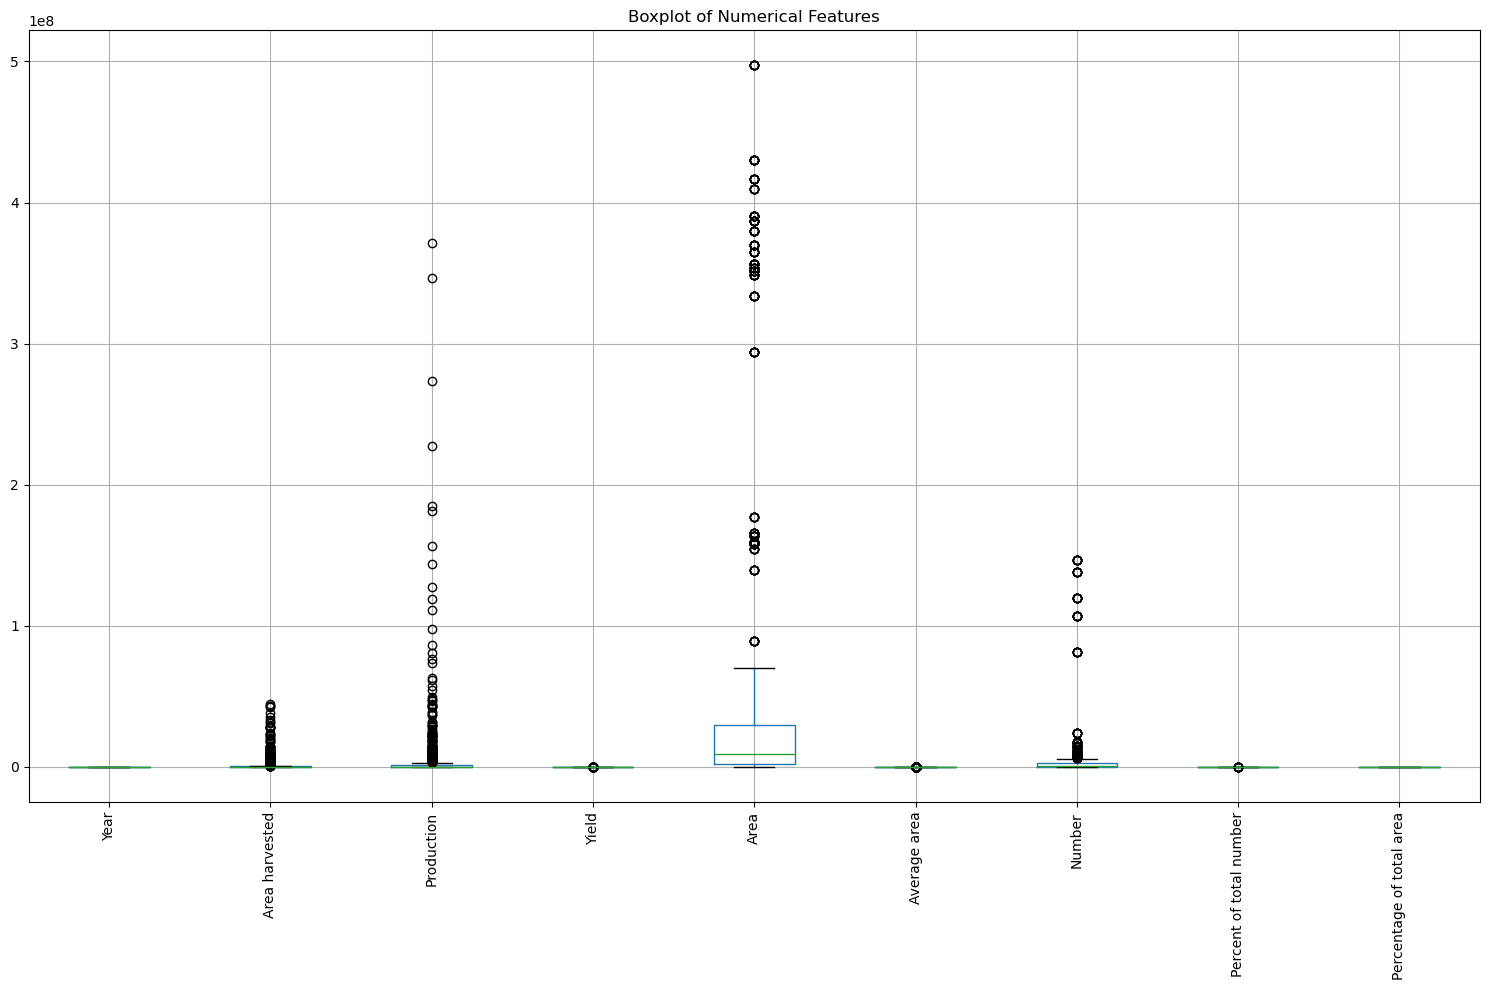

In [12]:
# Boxplot

num_cols = merged_df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15, 10))
merged_df[num_cols].boxplot(rot=90)
plt.title("Boxplot of Numerical Features")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [13]:
# Z-score method

z_scores = np.abs(stats.zscore(merged_df[num_cols]))
outliers = (z_scores > 3).sum(axis=1)
print("Number of outliers (Z-score > 3):", (outliers > 0).sum())

Number of outliers (Z-score > 3): 129


In [14]:
merged_df.columns

Index(['Country', 'Year', 'Item', 'Area harvested', 'Production', 'Yield',
       'Area', 'Average area', 'Number', 'Percent of total number',
       'Percentage of total area'],
      dtype='object', name='Element')

In [15]:
# Land per Holding = Total Area / Number of Holdings
merged_df['Land_per_Holding'] = merged_df['Area'] / merged_df['Number']

# Holding Size Check (optional sanity)
merged_df['Holding_Size_Diff'] = merged_df['Average area'] - merged_df['Land_per_Holding']


# Yield per Hectare (already exists, but we can recompute for validation)
merged_df['Yield_Calc'] = merged_df['Production'] / merged_df['Area harvested']


In [16]:
# Compute correlations (numeric only)

corr = merged_df.corr(numeric_only=True)

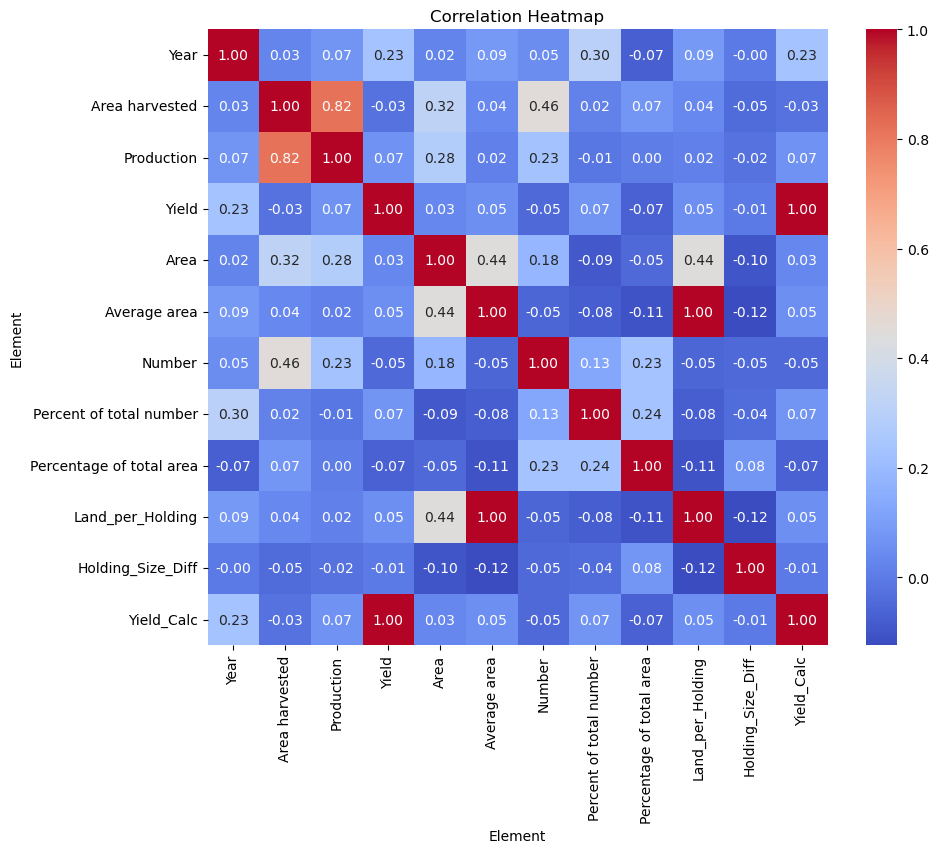

In [17]:
# Plot heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [18]:
# Drop rows with missing target

model_df = merged_df.dropna(subset=['Yield'])

In [19]:
# Define features and target

X = model_df.drop(columns=['Yield'])
y = model_df['Yield']

In [20]:
X

Element,Country,Year,Item,Area harvested,Production,Area,Average area,Number,Percent of total number,Percentage of total area,Land_per_Holding,Holding_Size_Diff,Yield_Calc
7,Albania,1998,Maize (corn),56599.0,189130.0,1889498.0,4.05,466809.0,99.98,23.92,4.047690,0.002310,3.341578
8,Albania,1998,Wheat,140910.0,395067.0,1889498.0,4.05,466809.0,99.98,23.92,4.047690,0.002310,2.803683
9,Albania,2012,Dates,442.0,12120.0,371609.0,1.16,321492.0,99.54,81.98,1.155889,0.004111,27.420814
10,Albania,2012,Maize (corn),53500.0,360000.0,371609.0,1.16,321492.0,99.54,81.98,1.155889,0.004111,6.728972
11,Albania,2012,Wheat,73000.0,300000.0,371609.0,1.16,321492.0,99.54,81.98,1.155889,0.004111,4.109589
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,Yugoslav SFR,1981,Maize (corn),2297000.0,9807000.0,11222124.0,4.19,2679581.0,99.88,82.26,4.188014,0.001986,4.269482
2552,Yugoslav SFR,1981,Millet,1000.0,2000.0,11222124.0,4.19,2679581.0,99.88,82.26,4.188014,0.001986,2.000000
2553,Yugoslav SFR,1981,Mixed grain,3600.0,5000.0,11222124.0,4.19,2679581.0,99.88,82.26,4.188014,0.001986,1.388889
2554,Yugoslav SFR,1981,Rice,8790.0,42000.0,11222124.0,4.19,2679581.0,99.88,82.26,4.188014,0.001986,4.778157


In [21]:
y

7        3341.6
8        2803.7
9       27420.8
10       6729.0
11       4109.6
         ...   
2551     4269.5
2552     2000.0
2553     1388.9
2554     4778.2
2555     3080.8
Name: Yield, Length: 1342, dtype: float64

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
X_train.shape

(1073, 13)

In [25]:
X_test.shape

(269, 13)

In [45]:
X_test.head()

Element,Country,Year,Item,Area harvested,Production,Area,Average area,Number,Percent of total number,Percentage of total area,Land_per_Holding,Holding_Size_Diff,Yield_Calc
1694,Peru,1961,"Coconuts, in shell",80.0,1000.0,17722044.0,20.37,869945.0,99.77,73.98,20.371453,-0.001453,12.500000
1097,Italy,2000,Wheat,2322840.0,7463968.0,19607094.0,7.57,2590674.0,86.76,68.33,7.568337,0.001663,3.213294
1176,Jordan,1983,Maize (corn),150.0,200.0,364263.0,5.86,62162.0,73.50,74.81,5.859898,0.000102,1.333333
871,Guatemala,1964,"Coffee, green",237000.0,105200.0,3476326.0,8.33,417344.0,57.88,77.45,8.329642,0.000358,0.443882
505,Cyprus,2010,Wheat,7833.0,18889.0,137760.0,3.55,38860.0,89.71,39.62,3.545033,0.004967,2.411464


In [46]:
X_train.head()

Element,Country,Year,Item,Area harvested,Production,Area,Average area,Number,Percent of total number,Percentage of total area,Land_per_Holding,Holding_Size_Diff,Yield_Calc
1702,Peru,1961,Wheat,153417.0,153595.0,17722044.0,20.37,869945.0,99.77,73.98,20.371453,-0.001453,1.001160
2461,Uruguay,1970,Maize (corn),227048.0,189413.0,16517730.0,214.06,77163.0,58.58,52.67,214.062828,-0.002828,0.834242
1237,Latvia,2010,Mixed grain,8100.0,15000.0,2879170.0,34.53,83390.0,95.23,42.77,34.526562,0.003438,1.851852
1919,Réunion,1972,Tea leaves,150.0,195.0,77231.0,1.97,39111.0,46.13,32.06,1.974662,-0.004662,1.300000
1798,Portugal,2009,Maize (corn),94727.0,634069.0,4709130.0,15.43,305270.0,94.02,56.10,15.426115,0.003885,6.693646


In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

In [48]:
#initializing models

In [49]:
lr_model=LinearRegression()
rf_model=RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model=XGBRegressor(n_estimators=100, random_state=42)
svr_model=SVR()
knn_model=KNeighborsRegressor(n_neighbors=5)
dt_model=DecisionTreeRegressor(random_state=42)
gbr_model=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

In [50]:
X.dtypes

Element
Country                      object
Year                          int32
Item                         object
Area harvested              float64
Production                  float64
Area                        float64
Average area                float64
Number                      float64
Percent of total number     float64
Percentage of total area    float64
Land_per_Holding            float64
Holding_Size_Diff           float64
Yield_Calc                  float64
dtype: object

In [53]:
X_encoded = pd.get_dummies(X, columns=['Country', 'Item'], drop_first=True)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

lr_model.fit(X_train, y_train)


LinearRegression()

In [54]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [55]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [56]:
svr_model.fit(X_train, y_train)

SVR()

In [57]:
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [58]:
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [59]:
gbr_model.fit(X_train, y_train)

GradientBoostingRegressor()

In [60]:
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_svr = svr_model.predict(X_test)
y_pred_knn= knn_model.predict(X_test)
y_pred_dt=dt_model.predict(X_test)
y_pred_gbr=gbr_model.predict(X_test)

In [61]:
#hyperparameter tuning

In [62]:
# For Random Forest


param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [63]:
# Grid Search for Random Forest

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='neg_mean_absolute_error')
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_absolute_error')

In [64]:
# Best parameters and score

print("Best Parameters for Random Forest:", grid_rf.best_params_)
print("Best MAE for Random Forest:", -grid_rf.best_score_)

Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best MAE for Random Forest: 53.31775491641798


In [65]:
# For XGBoost

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.7, 0.8, 1.0]
}

In [66]:
# Grid Search for XGBoost

grid_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=3, scoring='neg_mean_absolute_error')
grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='neg_mean_absolute_error')

In [67]:
# Best parameters and score

print("Best Parameters for XGBoost:", grid_xgb.best_params_)
print("Best MAE for XGBoost:", -grid_xgb.best_score_)

Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}
Best MAE for XGBoost: 80.1015881602459


In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [69]:
# ANN Model
# 64 neurons in the first layer
# 32 neurons in the second layer
# Output layer with a single neuron (for regression)


ann_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]), 
    Dense(32, activation='relu'),
    Dense(1)
])

C:\Users\Uer\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [70]:
# Compile the model

ann_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [71]:
ann_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2610029395968.0000 - mae: 559261.8750 - val_loss: 529056038912.0000 - val_mae: 273782.5938
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 300361973760.0000 - mae: 207211.0469 - val_loss: 110711300096.0000 - val_mae: 135533.5312
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 411119288320.0000 - mae: 181130.4062 - val_loss: 1358807826432.0000 - val_mae: 501381.0000
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 777082568704.0000 - mae: 286980.5938 - val_loss: 341782429696.0000 - val_mae: 281729.6562
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 175365406720.0000 - mae: 166270.7812 - val_loss: 20843335680.0000 - val_mae: 61037.8047
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18361143296.0000 - mae: 57956.3008 - val_loss: 16603817984.0000 - val_mae: 50649.7344
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20387356672.0000 - mae: 66099.1719 - val_loss: 152

In [72]:
# Evaluate the model

mae_ann = ann_model.evaluate(X_test, y_test)
print(f"Mean Absolute Error for ANN: {mae_ann[1]}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1175946880.0000 - mae: 16408.0293
Mean Absolute Error for ANN: 19605.07421875


In [73]:
# List of models

models = [lr_model,rf_model,xgb_model,dt_model,knn_model,svr_model,gbr_model,ann_model] 

In [74]:
# Evaluate each model

for model in models:
    if isinstance(model, Sequential):  # Check if it's an ANN
        y_pred = model.predict(X_test).flatten()  # ANN predictions
    else:
        y_pred = model.predict(X_test)  # For other models

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [75]:
# Evaluate function

def evaluate_model(name, model, X_test, y_test):
    if name == 'ANN':
        y_pred = model.predict(X_test).flatten()
    else:
        y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {'Model': name, 'MAE': mae, 'R2 Score': r2}


In [76]:
results = []
models = [
    ('Linear Regression', lr_model),
    ('Random Forest', rf_model),
    ('XGBoost', xgb_model),
    ('SVR', svr_model),
    ('KNN', knn_model),
    ('Decision Tree', dt_model),
    ('Gradient Boosting', gbr_model),
    ('ANN', ann_model)
]

for name, model in models:
    results.append(evaluate_model(name, model, X_test, y_test))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [77]:
results_df = pd.DataFrame(results).sort_values(by='MAE')
print(results_df)

               Model           MAE   R2 Score
0  Linear Regression      0.641929   0.999999
1      Random Forest     32.468480   0.999042
6  Gradient Boosting     39.894082   0.999299
5      Decision Tree     51.671375   0.997862
2            XGBoost     83.824466   0.994440
4                KNN   2641.266914   0.028819
3                SVR   2760.990503  -0.109176
7                ANN  19605.073757 -87.388972


C:\Users\Uer\AppData\Local\Temp\ipykernel_10880\43966263.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=results_df['Model'], x=results_df['MAE'], ax=axes[0], palette="coolwarm")
C:\Users\Uer\AppData\Local\Temp\ipykernel_10880\43966263.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=results_df['Model'], x=results_df['R2 Score'], ax=axes[1], palette="coolwarm")


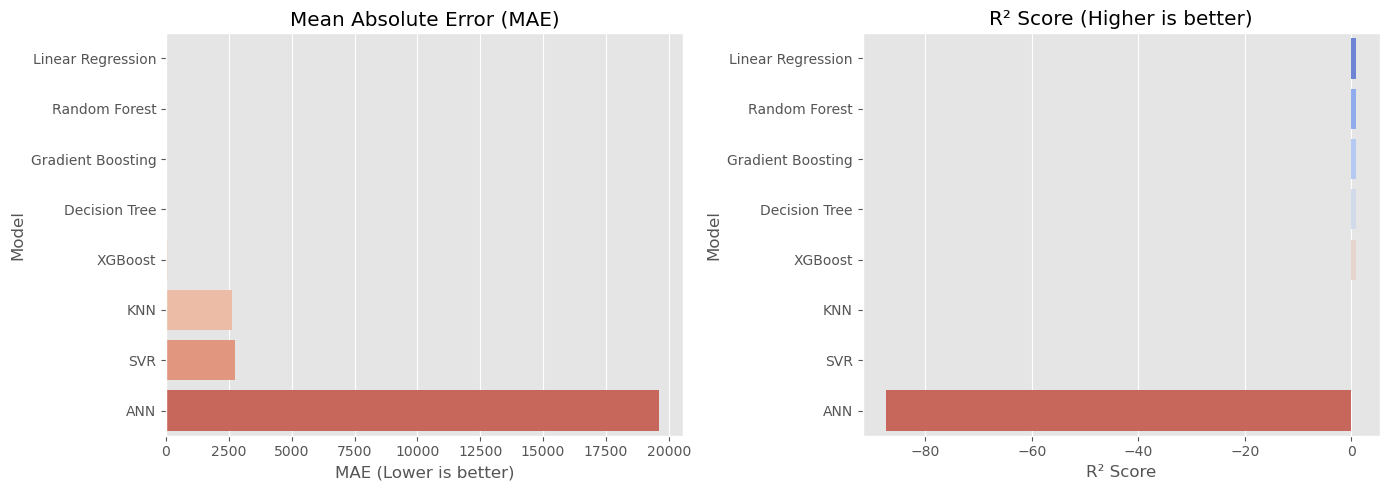

In [95]:

plt.style.use('ggplot')

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot MAE
sns.barplot(y=results_df['Model'], x=results_df['MAE'], ax=axes[0], palette="coolwarm")
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_xlabel('MAE (Lower is better)')

# Plot R² Score
sns.barplot(y=results_df['Model'], x=results_df['R2 Score'], ax=axes[1], palette="coolwarm")
axes[1].set_title('R² Score (Higher is better)')
axes[1].set_xlabel('R² Score')


plt.tight_layout()
plt.show()


In [78]:
# Sort by MAE 

results_df_sorted = results_df.sort_values(by='MAE')

In [79]:
# Create bar plots

plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

C:\Users\Uer\AppData\Local\Temp\ipykernel_10880\279193770.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MAE', y='Model', data=results_df_sorted, palette='viridis')


Text(0.5, 1.0, 'Model Comparison - MAE')

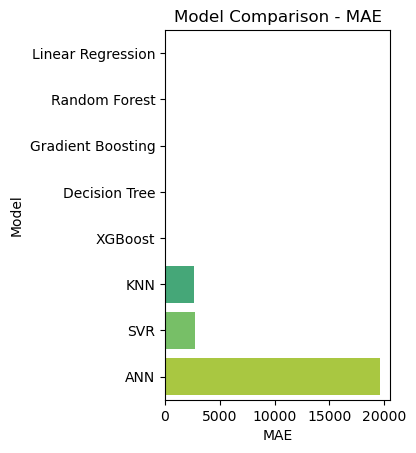

In [80]:
# MAE Plot

plt.subplot(1, 2, 1)
sns.barplot(x='MAE', y='Model', data=results_df_sorted, palette='viridis')
plt.title('Model Comparison - MAE')

C:\Users\Uer\AppData\Local\Temp\ipykernel_10880\3225978046.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2 Score', y='Model', data=results_df_sorted, palette='coolwarm')


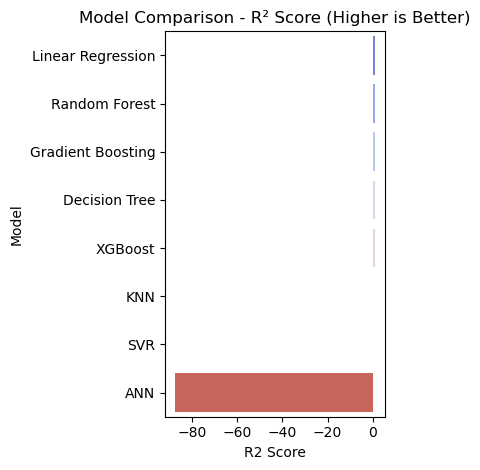

In [81]:
# R² Plot

plt.subplot(1, 2, 2)
sns.barplot(x='R2 Score', y='Model', data=results_df_sorted, palette='coolwarm')
plt.title('Model Comparison - R² Score (Higher is Better)')

plt.tight_layout()
plt.show()

C:\Users\Uer\AppData\Local\Temp\ipykernel_10880\4230740882.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_importance_df, palette='viridis')


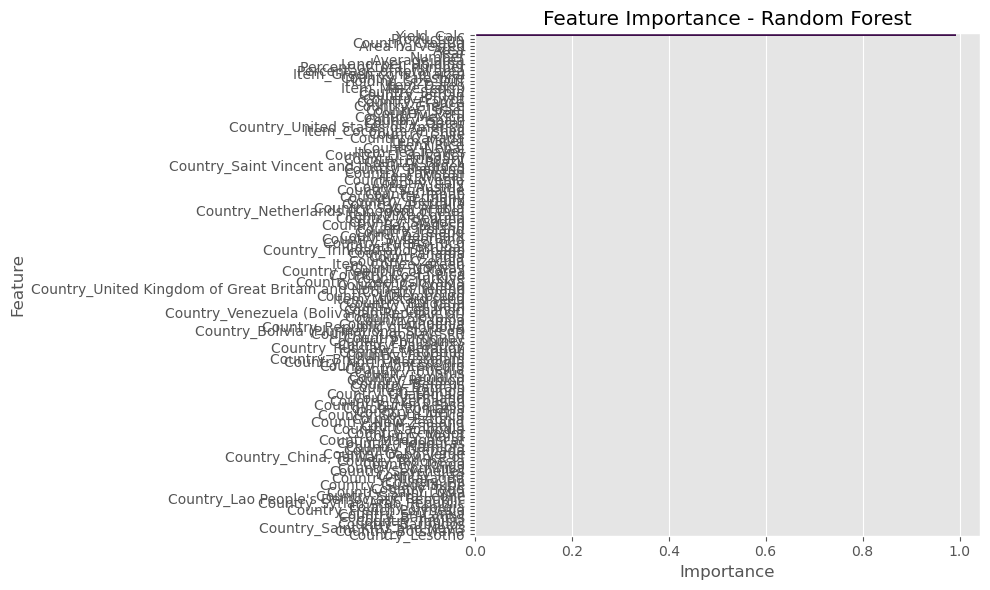

In [96]:
importances_rf = rf_model.feature_importances_
features = X_train.columns

# Create DataFrame
rf_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances_rf})
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

In [84]:
# Create a DataFrame to store predictions

predictions = {}

In [85]:
# Get predictions for each model

for name, model in models:
    if name == 'ANN':
        predictions[name] = ann_model.predict(X_test).flatten()
    else:
        predictions[name] = model.predict(X_test)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [86]:
# Convert to DataFrame

predictions_df = pd.DataFrame(predictions)
predictions_df['Actual'] = y_test.values

In [87]:
# Compute the correlation matrix

corr_matrix = predictions_df.corr()

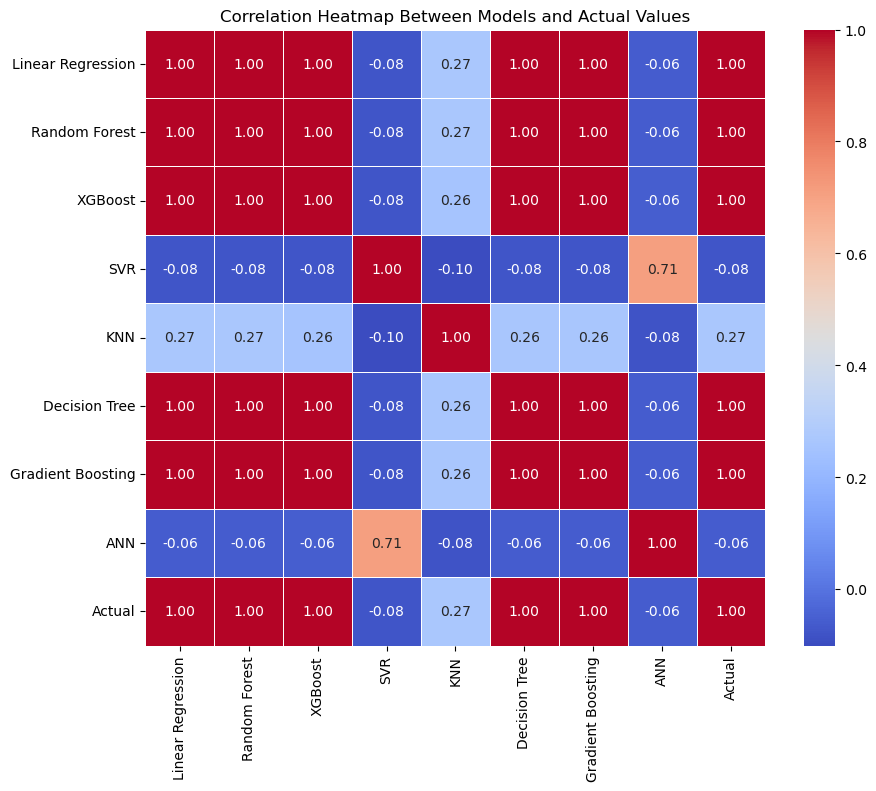

In [88]:
# Plot the heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap Between Models and Actual Values')
plt.show()

#Top Performers


Linear Regression - 0.64	~1.0    - Almost perfect fit
Random Forest     - 32.47 - 0.9990	- Excellent – realistic, robust model
Gradient Boosting - 39.89 - 0.9993	- Also very strong